# Planning and Stock Report Generation

## Setup

In [1]:
llm_config={"model": "gpt-4-turbo"}

## The task!

In [3]:
task = "Write a blogpost about the stock price performance of "\
"Nvidia in the past month. Today's date is 2024-08-10."

## Build a group chat

This group chat will include these agents:

1. **User_proxy** or **Admin**: to allow the user to comment on the report and ask the writer to refine it.
2. **Planner**: to determine relevant information needed to complete the task.
3. **Engineer**: to write code using the defined plan by the planner.
4. **Executor**: to execute the code written by the engineer.
5. **Writer**: to write the report.

In [4]:
import autogen

In [5]:
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

### Difference between System Message and Description

- System Message: <br>
    It is an instruction only meant for that particular Agent only <br>
- Description: <br>
    Instruction for other agents to let them know the role of this agent

In [6]:
planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    description="Planner. Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

In [7]:
engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    description="An engineer that writes code based on the plan "
    "provided by the planner.",
)

**Note**: In this lesson, you'll use an alternative method of code execution by providing a dict config. However, you can always use the LocalCommandLineCodeExecutor if you prefer. For more details about code_execution_config, check this: https://microsoft.github.io/autogen/docs/reference/agentchat/conversable_agent/#__init__

In [8]:
executor = autogen.ConversableAgent(
    name="Executor",
    system_message="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "coding",
        "use_docker": False,
    },
)

In [9]:
writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer."
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="Writer."
    "Write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog."
)

## Define the group chat

In [10]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=10,
)

In [11]:
# GroupChatManager - Special Agent in AutoGen to manage the group chat
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=llm_config
)


## Start the group chat!

In [12]:
groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)

Admin (to chat_manager):

Write a blogpost about the stock price performance of Nvidia in the past month. Today's date is 2024-08-10.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Planner (to chat_manager):

To write a blog post about the stock price performance of Nvidia for the past month, you'll need the following information, which can be retrieved using Python code:

1. **Historical Stock Prices for Nvidia for the last month**:
    - Dates: From 2024-07-10 to 2024-08-10
    - Data points: Daily closing stock prices, opening prices, highs, lows, and volume.

2. **Comparative Performance Data**:
    - Compare Nvidia’s stock performance to general market indices (e.g., S&P 500) during the same period.
    - Any notable industry trends that might affect tech stocks like Nvidia.

3. **Recent Company News and Events**:
    - Significant company news that might have influenced the stock price, such as new product releases,


--------------------------------------------------------------------------------
Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: exit


## Add a speaker selection policy

In [13]:
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    description="Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    description="Write code based on the plan "
    "provided by the planner.",
)

writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer. "
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="After all the info is available, "
    "write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog. ",
)

executor = autogen.ConversableAgent(
    name="Executor",
    description="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "coding",
        "use_docker": False,
    },
)

In [14]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=10,
    allowed_or_disallowed_speaker_transitions={ 
        user_proxy: [engineer, writer, executor, planner],
        engineer: [user_proxy, executor],
        writer: [user_proxy, planner],
        executor: [user_proxy, engineer, planner],
        planner: [user_proxy, engineer, writer],
    },
    speaker_transitions_type="allowed",
)

In [15]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=llm_config
)

groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)

Admin (to chat_manager):

Write a blogpost about the stock price performance of Nvidia in the past month. Today's date is 2024-08-10.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Planner (to chat_manager):

To write a blog post about the stock price performance of Nvidia for the past month, you'll need the following information, which can be retrieved using Python code:

1. **Historical Stock Prices for Nvidia for the last month**:
    - Dates: From 2024-07-10 to 2024-08-10
    - Data points: Daily closing stock prices, opening prices, highs, lows, and volume.

2. **Comparative Performance Data**:
    - Compare Nvidia’s stock performance to general market indices (e.g., S&P 500) during the same period.
    - Any notable industry trends that might affect tech stocks like Nvidia.

3. **Recent Company News and Events**:
    - Significant company news that might have influenced the stock price, such as new product releases,


--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
Executor (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 
                   Open         High  ...    Adj Close      Volume
Date                                  ...                         
2024-07-10  5591.259766  5635.390137  ...  5633.910156  3336100000
2024-07-11  5635.209961  5642.450195  ...  5584.540039  4020950000
2024-07-12  5590.759766  5655.560059  ...  5615.350098  3700280000
2024-07-15  5638.160156  5666.939941  ...  5631.220215  3620470000
2024-07-16  5644.089844  5669.669922  ...  5667.200195  4041760000
2024-07-17  5610.069824  5622.490234  ...  5588.270020  4246450000
2024-07-18  5608.560059  5614.049805  ...  5544.589844  4007510000
2024-07-19  5543.370117  5557.500000  ...  5505.000000  3760570000
2024-07-22  5544.540039  5570.359863  ...  5564.410156  3375180000
2024-07-23  5565.299805  5585.339844  


--------------------------------------------------------------------------------


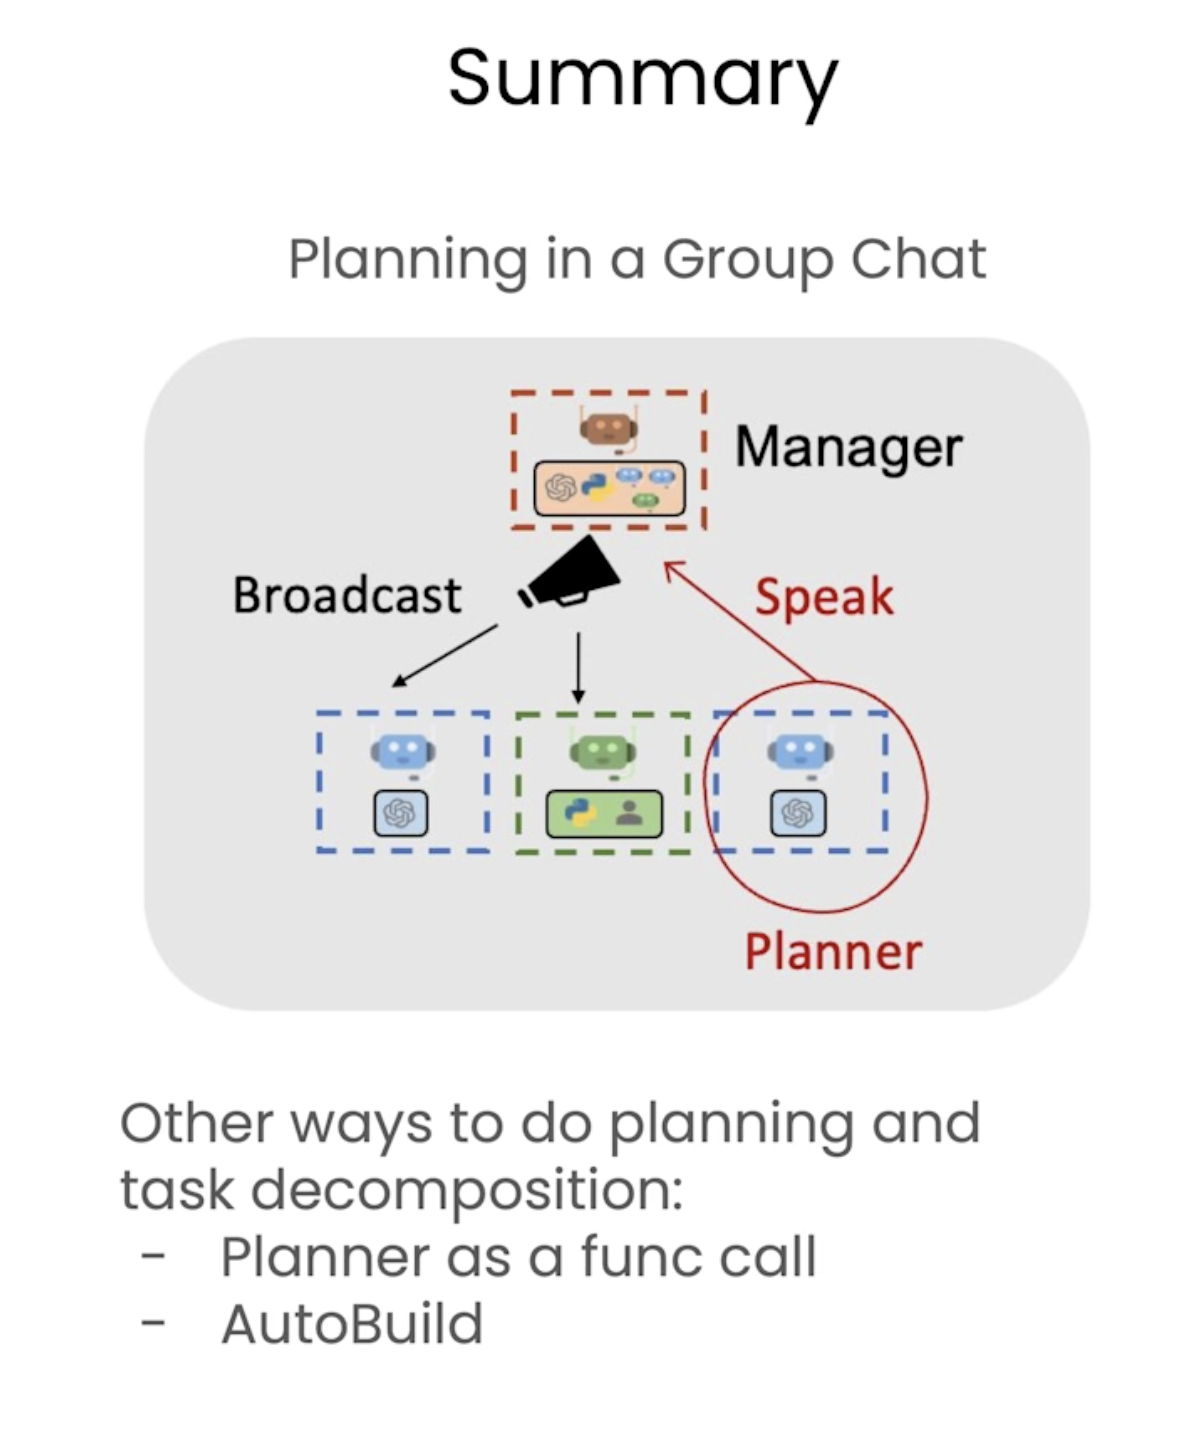